# Stochastic Gradient Descent
***

In this assignment we'll implement a rudimentary Stochastic Gradient Descent algorithm to learn the weights in simple linear regression.  Then we'll see if we can make it more efficient.  Finally, we'll investigate some graphical strategies for diagnosing convergence and tuning parameters. 

**Note**: The cell below has some helper functions.  Scroll down and evaluate those before proceeding. 

In [1]:
import numpy as np 
import matplotlib.pylab as plt 
import pytest
%matplotlib inline

In [2]:
mycolors = {"blue": "steelblue", "red":"#a76c6e",  "green":"#6a9373", "smoke": "#f2f2f2"}

def eval_RSS(X, y, b0, b1):
    rss = 0 
    for ii in range(len(df)):
        xi = df.loc[ii, "x"]
        yi = df.loc[ii, "y"]
        rss += (yi - (b0 + b1 * xi)) ** 2
    return rss

def plotsurface(X, y, bhist=None):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 300), np.linspace(-1, 5, 300))
    Z = np.zeros((xx.shape[0], yy.shape[0]))
    for ii in range(X.shape[0]):
        Z += (y[ii] - xx - yy * X[ii,1]) ** 2
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    levels = [125, 200] + list(range(400,2000,400))
    CS = ax.contour(xx, yy, Z, levels=levels)
    ax.clabel(CS, CS.levels, inline=True, fontsize=10)
    ax.set_xlim([-3,3])
    ax.set_ylim([-1,5])
    ax.set_xlabel(r"$\beta_0$", fontsize=20)
    ax.set_ylabel(r"$\beta_1$", fontsize=20)
    if bhist is not None:
        for ii in range(bhist.shape[0]-1):
            x0 = bhist[ii][0]
            y0 = bhist[ii][1]
            x1 = bhist[ii+1][0]
            y1 = bhist[ii+1][1]
            ax.plot([x0, x1], [y0, y1], color="black", marker="o", lw=1.5, markersize=5)

### Part 1: Setting Up Simulated Data and a Sanity Check 
***

We'll work with simulated data for this exercise where our generative model is given by 

$$
Y = 1 + 2X + \epsilon \textrm{ where} \epsilon \sim N(0, \sigma^2)
$$

**Part A**: The following function will generate data from the model. We'll grab a training set of size $n=100$ and a validation set of size $n = 50$.  

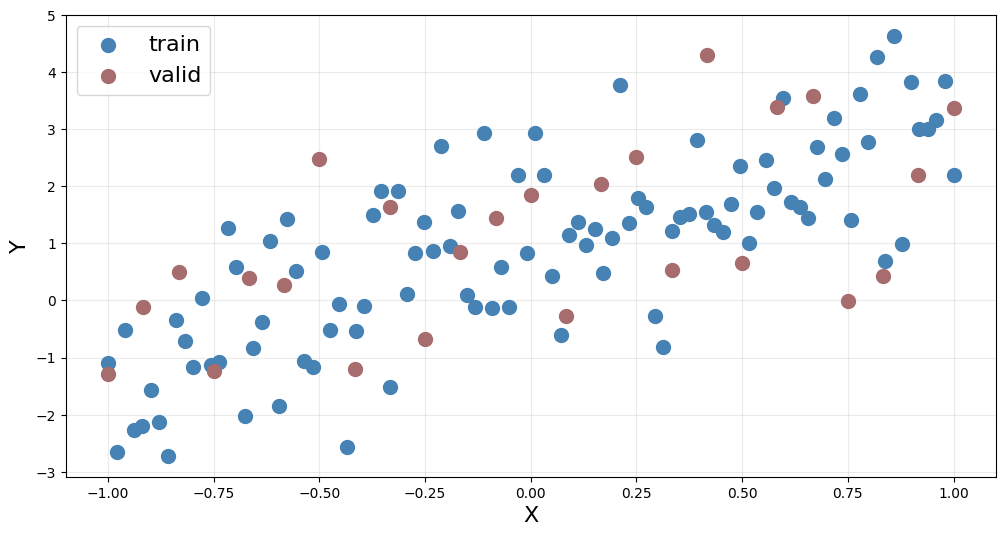

In [4]:
def dataGenerator(n, sigsq=1.0, random_state=1236):
    np.random.seed(random_state)
    x_train = np.linspace(-1, 1, n)
    x_valid = np.linspace(-1, 1, int(n / 4))
    y_train = 1 + 2 * x_train + np.random.randn(n)
    y_valid = 1 + 2 * x_valid + np.random.randn(int(n / 4))
    return x_train, x_valid, y_train, y_valid 

x_train, x_valid, y_train, y_valid = dataGenerator(100)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.scatter(x_train, y_train, color="steelblue", s=100, label="train")
ax.scatter(x_valid, y_valid, color="#a76c6e", s=100, label="valid")
ax.grid(alpha=0.25)
ax.set_axisbelow(True)
ax.set_xlabel("X", fontsize=16)
ax.set_ylabel("Y", fontsize=16)
ax.legend(loc="upper left", fontsize=16)